In [1]:
# Square graph
square_graph = [(0, 1), (1, 2), (2, 3), (3, 0)]

from typing import List, Tuple

def count_cuts(graph: List[Tuple[int]], set_a: set, set_b: set):
    """Counts the number of cuts of a graph bipartition."""
    num_cuts = 0
    for edge in graph:
        if edge[0] in set_a and edge[1] in set_b:
            num_cuts += 1
        if edge[0] in set_b and edge[1] in set_a:
            num_cuts += 1
    return num_cuts

set_a = {0, 2}
set_b = {1, 3}

count_cuts(square_graph, set_a, set_b)

4

#### A handy way of representing a candidate solution of the MaxCut problem, is to use a bitstring in which each bit is associated to the node of the graph. The value of each bit, or, can be used to represent the corresponding subset, or, to which the node belongs. ####

In [2]:
def count_cuts_from_string(graph: List[Tuple[int]], bitstring: str):
    """Counts the number of cuts of a graph bipartition represented as a (big-endian) bitstring.
    """
    cost = 0
    for i, j in graph:
        z1 = (2 * int(bitstring[-i]) - 1)
        z2 = (2 * int(bitstring[-j]) - 1)
        cost += -(1 - z1 * z2) // 2
    return -cost

optimal_string = "1010"
# Test the function
count_cuts_from_string(square_graph, optimal_string)

4

In [5]:
from cirq import NamedQubit, Circuit, identity_each, ZZ
import numpy as np

def qaoa_hamiltonian(graph: List[Tuple[float]]) -> np.ndarray:
    """Returns the cost Hamiltonian associated to the input graph.
    """
    # Get all the nodes of the graph
    nodes = list({node for edge in graph for node in edge})
    # Initialize the qubits. One for each node.
    qreg = [NamedQubit(str(nn)) for nn in nodes]
    # Define the Hamiltonian as a NumPy array
    np_identity = np.eye(2 ** len(nodes))
    zz_terms = np.real([Circuit([identity_each(*qreg), ZZ(qreg[i], qreg[j])]).unitary() for i, j in graph])
    local_terms = [-0.5 * (np_identity - zz_term) for zz_term in zz_terms]
    return sum(local_terms)


eig_vals = np.diag(qaoa_hamiltonian(square_graph))
# Ground state energy
min(eig_vals)

# The associated optimal eigenstates are:
nodes = list({node for edge in square_graph for node in edge})
num_nodes = len(nodes)
optimal_bitstrings = [f"{j:b}".zfill(num_nodes) for j, eig_val in enumerate(eig_vals) if eig_val == min(eig_vals)]
optimal_bitstrings

['0101', '1010']

# Using the Quantum Approximate Optimization Algorithm to find the ground state #

In [7]:
from cirq import H, X
from typing import List, Tuple

def qaoa_ansatz(graph: List[Tuple[float]], params: List[float]) -> Circuit:
    """Generates a QAOA circuit associated to the input graph, for
    a specific choice of variational parameters.

    Args:
        graph: The input graph.
        params: The variational parameters.

    Returns:
        The QAOA circuit.
    """

    # Get the list of unique nodes from the list of edges
    nodes = list({node for edge in graph for node in edge})

    # Initialize the qubits
    qreg = [NamedQubit(str(nn)) for nn in nodes]

    # Define the Hamiltonian evolution (up to an additive and a multiplicative constant)
    def h_step(beta: float) -> Circuit:
        return Circuit(ZZ(qreg[u], qreg[v]) ** (beta) for u, v in graph)

    # Define the mixing evolution (up to an additive and a multiplicative constant)
    def mix_step(gamma: float) -> Circuit:
        return Circuit(X(qq) ** gamma for qq in qreg)

    # State preparation layer
    circ = Circuit(H.on_each(qreg))

    # Apply QAOA steps
    num_steps = len(params) // 2
    betas, alphas = params[:num_steps], params[num_steps:]
    for beta, alpha in zip(betas, alphas):
        circ.append([h_step(beta) + mix_step(alpha)])

    return circ

In [8]:
betas = [0.1, 0.2]
alphas = [0.3, 0.4]
params = betas + alphas
qaoa_ansatz(square_graph, params)

0: ───H───ZZ─────────────────────────ZZ───────X^0.3───ZZ─────────────────────────ZZ───────X^0.4───
          │                          │                │                          │
1: ───H───ZZ^0.1───ZZ────────────────┼────────X^0.3───ZZ^0.2───ZZ────────────────┼────────X^0.4───
                   │                 │                         │                 │
2: ───H────────────ZZ^0.1───ZZ───────┼────────X^0.3────────────ZZ^0.2───ZZ───────┼────────X^0.4───
                            │        │                                  │        │
3: ───H─────────────────────ZZ^0.1───ZZ^0.1───X^0.3─────────────────────ZZ^0.2───ZZ^0.2───X^0.4───

In [10]:
from cirq import depolarize, DensityMatrixSimulator

def executor(circ: Circuit, obs: np.array, noise: float) -> float:
    """Simulates a circuit with depolarizing noise at level 'noise' and returns the
    expectation value of the observable 'obs'.
    """
    SIMULATOR = DensityMatrixSimulator()
    # Add the noise
    noisy_circ = circ.with_noise(depolarize(p=noise))
    # Get the final quantum state
    rho = SIMULATOR.simulate(noisy_circ).final_density_matrix
    # Return the expectation value
    return np.real(np.trace(rho @ obs))

betas = [0.1, 0.2]
alphas = [0.3, 0.4]
params = betas + alphas
circuit = qaoa_ansatz(square_graph, params)
hamiltonian = qaoa_hamiltonian(square_graph)
executor(circuit, obs=hamiltonian, noise=0)

-1.4574782699346542

# Minimization of the QAOA cost #

In [11]:
from typing import Callable
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def minimize_cost(
    cost_function: Callable[[np.array], float],
    init_params: np.array,
) -> Tuple[float, np.ndarray, List[float]]:
    """Minimizes a cost function which depends on an array variational parameters.

    Args:
        cost_function: The cost function to minimize.
        init_params: The initial variational parameters.

    Returns:
        A triple of the minimum cost, the optimal parameters and a list of costs at each iteration steps.
    """


    # store the optimization trajectory
    traj = []

    def callback(xk: np.ndarray) -> bool:
        traj.append(cost_function(xk))
        return True

    results = minimize(
        cost_function,
        x0=init_params,
        method="Nelder-Mead",
        callback=callback,
        options={"disp": True, "maxiter": 300},
        # Set tol=0 to enforce a fixed number of iterations.
        # Comment tol=0 to speedup the notebook execution.
        tol=0,
    )

    plt.title("Optimization history")
    plt.xlabel("Iteration Step")
    plt.ylabel("Cost")
    plt.plot(traj)
    plt.show()
    return results.fun, results.x, traj

C:\Users\kakal\AppData\Local\Temp\ipykernel_15112\3419589073.py:27: RuntimeWarning: Maximum number of iterations has been exceeded.
  results = minimize(


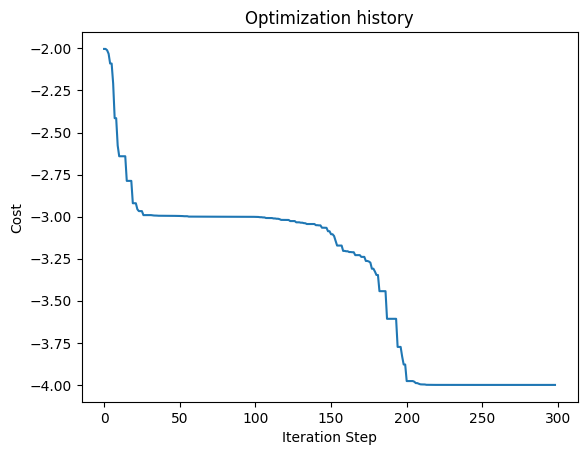

Ideal cost:  -4.0


In [12]:
graph = [(0, 1), (1, 2), (2, 3), (3, 0)]
betas = [0.0, 0.5]
gammas = [0.7, 1.0]
init_params = betas + gammas

def qaoa_ideal_cost(params: np.array) -> float:
    """Ideal cost function of the QAOA problem without noise."""
    qaoa_circuit = qaoa_ansatz(graph, params)
    qaoa_obs = qaoa_hamiltonian(graph)
    return executor(qaoa_circuit, qaoa_obs, noise=0)

ideal_opt_cost, ideal_opt_params, traj = minimize_cost(qaoa_ideal_cost, init_params)
print("Ideal cost: ", np.round(ideal_opt_cost, 4))

# Noisy Unmitigated Hardware #

C:\Users\kakal\AppData\Local\Temp\ipykernel_15112\3419589073.py:27: RuntimeWarning: Maximum number of iterations has been exceeded.
  results = minimize(


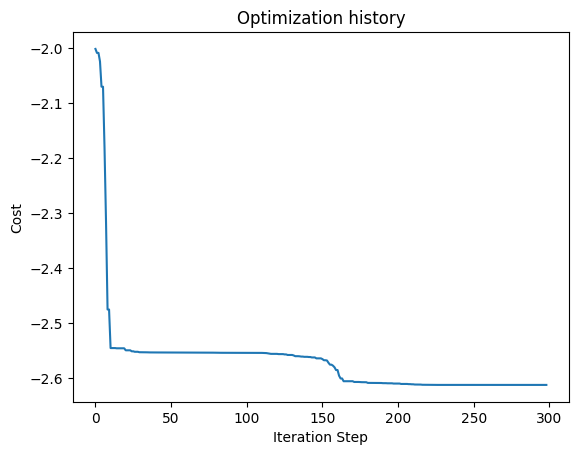

In [13]:
BASE_NOISE = 0.03
def qaoa_noisy_cost(params: np.array) -> float:
    """Noisy cost function of the QAOA problem."""
    qaoa_circuit = qaoa_ansatz(graph, params)
    qaoa_obs = qaoa_hamiltonian(graph)
    return executor(qaoa_circuit, qaoa_obs, noise=BASE_NOISE)

noisy_opt_cost, noisy_opt_params, noisy_traj = minimize_cost(qaoa_noisy_cost, init_params)

In [14]:
print("Noisy cost: ", np.round(noisy_opt_cost, 4))
print("Ideal cost evaluated at noisy parameters: ", np.round(qaoa_ideal_cost(noisy_opt_params), 4))
print("Ideal cost: ", np.round(ideal_opt_cost, 4))

Noisy cost:  -2.6122
Ideal cost evaluated at noisy parameters:  -3.2278
Ideal cost:  -4.0


# Mitigated noisy hardware using Mitiq

C:\Users\kakal\AppData\Local\Temp\ipykernel_15112\3419589073.py:27: RuntimeWarning: Maximum number of iterations has been exceeded.
  results = minimize(


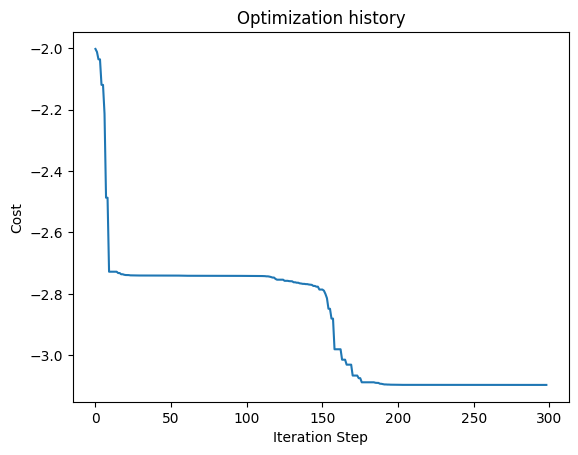

In [15]:
import mitiq
from mitiq.zne import mitigate_executor
from functools import partial

# Choose a noise scaling method
scaling_method = mitiq.zne.scaling.fold_global

# Initialize an inference method (i.e. a Mitiq Factory)
inference_factory = mitiq.zne.inference.LinearFactory(scale_factors=[1.0, 3.0])

# Define the cost function
def qaoa_mitigated_cost(params: np.array) -> float:
    """Cost function of the QAOA problem using error mitigation."""
    qaoa_circuit = qaoa_ansatz(graph, params)
    qaoa_obs = qaoa_hamiltonian(graph)
    noisy_executor = partial(executor, obs=qaoa_obs, noise=BASE_NOISE)
    mitigated_executor = mitigate_executor(noisy_executor, factory=inference_factory, scale_noise=scaling_method)
    return mitigated_executor(qaoa_circuit)

# Minimize the cost function
mitig_opt_cost, mitig_opt_params, mitig_traj = minimize_cost(qaoa_mitigated_cost, init_params)

In [16]:
print("Mitigated cost: ", np.round(mitig_opt_cost, 4))
print("Noisy cost evaluated at noisy parameters: ", np.round(noisy_opt_cost, 4))
print("Noisy cost evaluated at mitigated parameters: ",np.round(qaoa_noisy_cost(mitig_opt_params), 4))
print("Ideal cost evaluated at noisy parameters: ", np.round(qaoa_ideal_cost(noisy_opt_params), 4))
print("Ideal cost evaluated at mitigated parameters: ", np.round(qaoa_ideal_cost(mitig_opt_params), 4))
print("Ideal cost: ", np.round(ideal_opt_cost, 4))

Mitigated cost:  -3.0967
Noisy cost evaluated at noisy parameters:  -2.6122
Noisy cost evaluated at mitigated parameters:  -2.7841
Ideal cost evaluated at noisy parameters:  -3.2278
Ideal cost evaluated at mitigated parameters:  -3.9337
Ideal cost:  -4.0
